# Impact of waves on Langmuir turbulence and mixed layer depths

This notebook shows a comparison between three experiments all using MOM–CICE–WW3:
- `IC4M8-MCW-100km_jra_ryf_ePBL`: ePBL with `WAVE_METHOD="SURFACE_BANDS"` and `LMPENABLED=F` (see config [here](https://github.com/NoahDay/access-om3-configs/tree/noah-IC4M8-MCW-100km_jra_ryf_ePBL))
- `IC4M8-MCW-100km_jra_ryf_KPP`: KPP with `WAVE_METHOD="EFACTOR"` and `LMPENABLED=T` (see config [here](https://github.com/NoahDay/access-om3-configs/tree/noah-IC4M8-MCW-100km_jra_ryf_KPP))
- `IC4M8-MCW-100km_jra_ryf`: ePBL but Langmuir turbulence is not enhanced by WW3 (`USE_WAVES=FALSE`), similar to MOM–CICE configurations (see config [here](https://github.com/NoahDay/access-om3-configs/tree/noah-IC4M8-MCW-100km_jra_ryf))


**TO-DO**:
- More diagnostics than MLD? (SST, TKE?)

In [6]:
#This cell must be in all notebooks!
#It allows us to run all the notebooks at once, this cell has a tag "parameters" which allows us to pass in 
# arguments externally using papermill (see mkfigs.sh for details)

### USER EDIT start
esm_epbl = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_ePBL/experiment_datastore.json"
# esm_kpp = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_kpp/experiment_datastore.json"
esm_ctrl = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf/experiment_datastore.json"

dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ePBL datastore path: ",esm_epbl)
# print("KPP datastore path: ",esm_kpp)
print("CTRL datastore path: ",esm_ctrl)
print("Plot folder path: ",plotfolder)

ePBL datastore path:  /scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_ePBL/experiment_datastore.json
CTRL datastore path:  /scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf/experiment_datastore.json
Plot folder path:  /g/data/ps29/nd0349/access-om3-paper-figs/


## Load in libraries

In [7]:
import xarray as xr
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
from pint import application_registry as ureg
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.colors import LogNorm
from distributed import Client
import cftime
import os
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from textwrap import wrap
xr.set_options(keep_attrs=True);  # cf_xarray works best when xarray keeps attributes by default

In [8]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


## Define plotting functions

In [9]:
blue_marble = plt.imread('/g/data/ik11/grids/BlueMarble.tiff')
blue_marble_extent = (-180, 180, -90, 90)

In [10]:
def get_proj(hemisphere):
    if hemisphere.lower().startswith('s'):
        projection = ccrs.SouthPolarStereo(central_longitude=0)
        extent = [-180, 180, -90, -40]
    elif hemisphere.lower().startswith('n'):
        projection = ccrs.Stereographic(
            central_latitude=90.0,
            central_longitude=-45.0,
            true_scale_latitude=60.0,
            globe=ccrs.Globe(semimajor_axis=6378273.0, semiminor_axis=6356889.448910593)
        )
        extent = [0, 360, 40, 90]
    else:
        raise ValueError("hemisphere must be 'north' or 'south'")
    return projection, extent

def make_fig(number_panels=1, hemisphere='south'):
   
    projection, extent = get_proj(hemisphere)
    
    fig, axes = plt.subplots(
        ncols=number_panels,
        subplot_kw={'projection': projection},
        figsize=(4 * number_panels, 4),
        gridspec_kw={'wspace': 0.25, 'hspace': 0.15}
    )

    
    for ax in axes:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
       # Add land texture:
        ax.imshow(
            blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
        )
        # Make a circle plot
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_title("NO DATA")

    return fig, axes

def plot(dat,  dat_ice=None, ax=None, title=None, hemisphere='south', label="", vmin=None, vmax=None, **kwargs):
    if title is None:
    #     # title = dat.attrs['long_name']
        title = "NO DATA"
        
    if ax == None:
        fig, ax = make_fig(hemisphere='south')
    
    dat.plot.contourf(
        ax=ax,
        x="lon", 
        y="lat", 
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={"label": label, # "\n".join(wrap(f"{dat.attrs['long_name']} [{dat.attrs['units']}]", 45))
                     "fraction": 0.03, "aspect": 15, "shrink": 0.7},
        **kwargs
    )
    ax.set_title(title);
    if dat_ice is not None:
        add_ice_contours(ax, dat_ice, hemisphere)

def add_ice_contours(ax, dat_ice, hemisphere):

    projection, extent = get_proj(hemisphere)
        
    transformed_coor=projection.transform_points(ccrs.PlateCarree(),dat_ice['lon'].values,dat_ice['lat'].values)
    x_ster,y_ster=transformed_coor[:,:,0],transformed_coor[:,:,1]
    use_transformed_coordinates_directly = True
    
    if use_transformed_coordinates_directly:
        cs = ax.contour(x_ster,y_ster,dat_ice['aice_m'],levels=[1e-12, 0.15, 0.8],linestyles=[":", "-", "--"],colors="magenta",linewidths=0.5)
    else:
        cs = ax.contour(dat_ice['lon'],dat_ice['lat'],dat_ice['aice_m'],levels=[1e-12, 0.15, 0.8],transform=ccrs.PlateCarree(),
                    linestyles=[":", "-", "--"],colors="magenta",linewidths=0.5)
                
    return cs

### Open the intake-esm datastore

In [11]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore_epbl = intake.open_esm_datastore(
    esm_epbl,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)

# datastore_kpp = intake.open_esm_datastore(
#     esm_kpp,
#     columns_with_iterables=COLUMNS_WITH_ITERABLES
# )

datastore_ctrl = intake.open_esm_datastore(
    esm_ctrl,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)

### What ocean variables are available at monthly frequency?

In [12]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [13]:
datastore_filtered = datastore_epbl.search(realm="ocean", frequency="1mon")

available_variables(datastore_filtered)

variable_long_name  \
variable                                                              
KE                               Layer kinetic energy per unit mass   
agessc                                             Ideal Age Tracer   
average_DT                                 Length of average period   
average_T1                            Start time for average period   
average_T2                              End time for average period   
hfds              Surface ocean heat flux from SW+LW+latent+sens...   
hfrainds          Heat content (relative to 0degC) of liquid+fro...   
hfrunoffds        Heat content (relative to 0C) of liquid+solid ...   
mlotst               Ocean Mixed Layer Thickness Defined by Sigma T   
mlotst_max           Ocean Mixed Layer Thickness Defined by Sigma T   
net_heat_coupler  Surface ocean heat flux from SW+LW+latent+sens...   
nv                                                    vertex number   
pbo                                 Sea Water Pressure at Sea Floor   
pso                         Sea Water Pressure at Sea Water Surface   
rhopot2                   Potential density referenced to 2000 dbar   
salt_flux_added   Salt flux into ocean at surface due to restori...   
sfdsi                              Downward Sea Ice Basal Salt Flux   
so                                                         Salinity   
speed                                             Sea Surface Speed   
tauuo                                     Surface Downward X Stress   
tauvo                                     Surface Downward Y Stress   
thetao                                        Potential Temperature   
time                                                           time   
time_bnds                                      time axis boundaries   
umo_2d                          Ocean Mass X Transport Vertical Sum   
uo                                             Sea Water X Velocity   
vmo_2d                          Ocean Mass Y Transport Vertical Sum   
vo                                             Sea Water Y Velocity   
wfo                                       Water Flux Into Sea Water   
xh                                        h point nominal longitude   
xq                                        q point nominal longitude   
yh                                         h point nominal latitude   
yq                                         q point nominal latitude   
z_i                                              Depth at interface   
z_l                                            Depth at cell center   
zos                                  Sea surface height above geoid   
zossq                      Square of sea surface height above geoid   

                                             variable_standard_name  \
variable                                                              
KE                                                                    
agessc                                             ideal_age_tracer   
average_DT                                                            
average_T1                                                            
average_T2                                                            
hfds                        surface_downward_heat_flux_in_sea_water   
hfrainds          temperature_flux_due_to_rainfall_expressed_as_...   
hfrunoffds        temperature_flux_due_to_runoff_expressed_as_he...   
mlotst               ocean_mixed_layer_thickness_defined_by_sigma_t   
mlotst_max           ocean_mixed_layer_thickness_defined_by_sigma_t   
net_heat_coupler                                                      
nv                                                                    
pbo                                 sea_water_pressure_at_sea_floor   
pso                         sea_water_pressure_at_sea_water_surface   
rhopot2                                                               
salt_flux_added                                                       
s

### Load monthly MLD (`mlotst`), SST (``), and sea ice concentration (`aice_m`)

In [14]:
mld_epbl = datastore_epbl.search(variable="mlotst", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

coords = datastore_epbl.search(variable=["geolat", "geolon"], file_id='access_om3_mom6_static'
                         ).to_dask().compute() # TODO why do we need file_id for my runs??
coords = coords.fillna(0.0)
coords = coords.rename({'geolat': 'lat', 'geolon': 'lon'})
mld_epbl = mld_epbl.assign_coords(coords)


sst_epbl = datastore_epbl.search(variable="thetao", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
sst_epbl = sst_epbl.assign_coords(coords)

aice_epbl = datastore_epbl.search(variable="aice_m", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
aice_epbl = aice_epbl.assign_coords(coords)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


In [15]:
# mld_kpp = datastore_kpp.search(variable="mlotst", frequency="1mon").to_dask(
#     xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
#         compat="override",
#         data_vars="minimal",
#         coords="minimal",
#     ),
#     xarray_open_kwargs = dict(
#         chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
#         decode_timedelta=True
#     )
# )
# coords = datastore_kpp.search(variable=["geolat", "geolon"], file_id='access_om3_mom6_static'
#                          ).to_dask().compute() # TODO why do we need file_id for my runs??
# coords = coords.fillna(0.0)
# coords = coords.rename({'geolat': 'lat', 'geolon': 'lon'})
# mld_kpp = mld_kpp.assign_coords(coords)

# aice_kpp = datastore_kpp.search(variable="aice_m", frequency="1mon").to_dask(
#     xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
#         compat="override",
#         data_vars="minimal",
#         coords="minimal",
#     ),
#     xarray_open_kwargs = dict(
#         chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
#         decode_timedelta=True
#     )
# )
# aice_kpp = aice_kpp.assign_coords(coords)

In [16]:
mld_ctrl = datastore_ctrl.search(variable="mlotst", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

coords = datastore_ctrl.search(variable=["geolat", "geolon"], file_id='access_om3_mom6_static'
                         ).to_dask().compute() # TODO why do we need file_id for my runs??
coords = coords.fillna(0.0)
coords = coords.rename({'geolat': 'lat', 'geolon': 'lon'})
mld_ctrl = mld_ctrl.assign_coords(coords)

sst_ctrl = datastore_ctrl.search(variable="thetao", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
sst_ctrl = sst_ctrl.assign_coords(coords)

aice_ctrl = datastore_ctrl.search(variable="aice_m", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
aice_ctrl = aice_ctrl.assign_coords(coords)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


### Load and plot obs data from DeBoyer Montegut (2023)
https://doi.org/10.17882/91774

In [17]:
MLDobs = xr.open_dataset('/g/data/av17/access-nri/OM3/MLD-DeBoyerMontegut2023/mld_dr003_ref10m_v2023.nc')['mld_dr003']
MLDobs.attrs['units'] = MLDobs.attrs['unit']  # fix so plot works

# TODO: append copy of westernmost data to eastern end to avoid gap in plot

In [18]:
# small BUG: mean of monthly means is not mean of days in that month (eg Feb gets slightly more heavily weighted)
MLDobs_JFM_mean = MLDobs.isel(time=[0, 1, 2]).mean('time').load()
MLDobs_JAS_mean = MLDobs.isel(time=[6, 7, 8]).mean('time').load()

## Plot ACCESS-OM3-MCW data
Average mixed layer depths from January–March and June–September.

In [19]:
model_monthly_mld_epbl = mld_epbl.groupby('time.month').mean('time')
model_JFM_mld_epbl = model_monthly_mld_epbl.sel(month=slice(1,3)).mean('month').load()
model_JAS_mld_epbl = model_monthly_mld_epbl.sel(month=slice(7,9)).mean('month').load()

# model_monthly_mld_kpp = mld_kpp.groupby('time.month').mean('time')
# model_JFM_mld_kpp = model_monthly_mld_kpp.sel(month=slice(1,3)).mean('month').load()
# model_JAS_mld_kpp = model_monthly_mld_kpp.sel(month=slice(7,9)).mean('month').load()

model_monthly_mld_ctrl = mld_ctrl.groupby('time.month').mean('time')
model_JFM_mld_ctrl = model_monthly_mld_ctrl.sel(month=slice(1,3)).mean('month').load()
model_JAS_mld_ctrl = model_monthly_mld_ctrl.sel(month=slice(7,9)).mean('month').load()

Average sea ice concentrations from January–March and June–September.

In [20]:
model_monthly_aice_epbl = aice_epbl.groupby('time.month').mean('time')
model_JFM_aice_epbl = model_monthly_aice_epbl.sel(month=slice(1,3)).mean('month').load()
model_JAS_aice_epbl = model_monthly_aice_epbl.sel(month=slice(7,9)).mean('month').load()

# model_monthly_aice_kpp = aice_kpp.groupby('time.month').mean('time')
# model_JFM_aice_kpp = model_monthly_aice_kpp.sel(month=slice(1,3)).mean('month').load()
# model_JAS_aice_kpp = model_monthly_aice_kpp.sel(month=slice(7,9)).mean('month').load()

model_monthly_aice_ctrl = aice_ctrl.groupby('time.month').mean('time')
model_JFM_aice_ctrl = model_monthly_aice_ctrl.sel(month=slice(1,3)).mean('month').load()
model_JAS_aice_ctrl = model_monthly_aice_ctrl.sel(month=slice(7,9)).mean('month').load()

Get experiment start and end dates.

In [21]:
exptname_epbl = os.path.basename(os.path.dirname(esm_epbl))
datestart_epbl = mld_epbl.convert_calendar("proleptic_gregorian", use_cftime=True).time.values[0]
datestop_epbl = mld_epbl.convert_calendar("proleptic_gregorian", use_cftime=True).time.values[-1]

In [22]:
# exptname_kpp = os.path.basename(os.path.dirname(esm_kpp))
# datestart_kpp = mld_kpp.convert_calendar("proleptic_gregorian", use_cftime=True).time.values[0]
# datestop_kpp = mld_kpp.convert_calendar("proleptic_gregorian", use_cftime=True).time.values[-1]

In [23]:
exptname_ctrl= os.path.basename(os.path.dirname(esm_ctrl))
datestart_ctrl = mld_ctrl.convert_calendar("proleptic_gregorian", use_cftime=True).time.values[0]
datestop_ctrl = mld_ctrl.convert_calendar("proleptic_gregorian", use_cftime=True).time.values[-1]

### Plot the MLD for the Arctic Ocean

Text(0.5, 0.95, 'Ocean Mixed Layer Thickness Defined by Sigma T (m) for JFM 1900—1902')

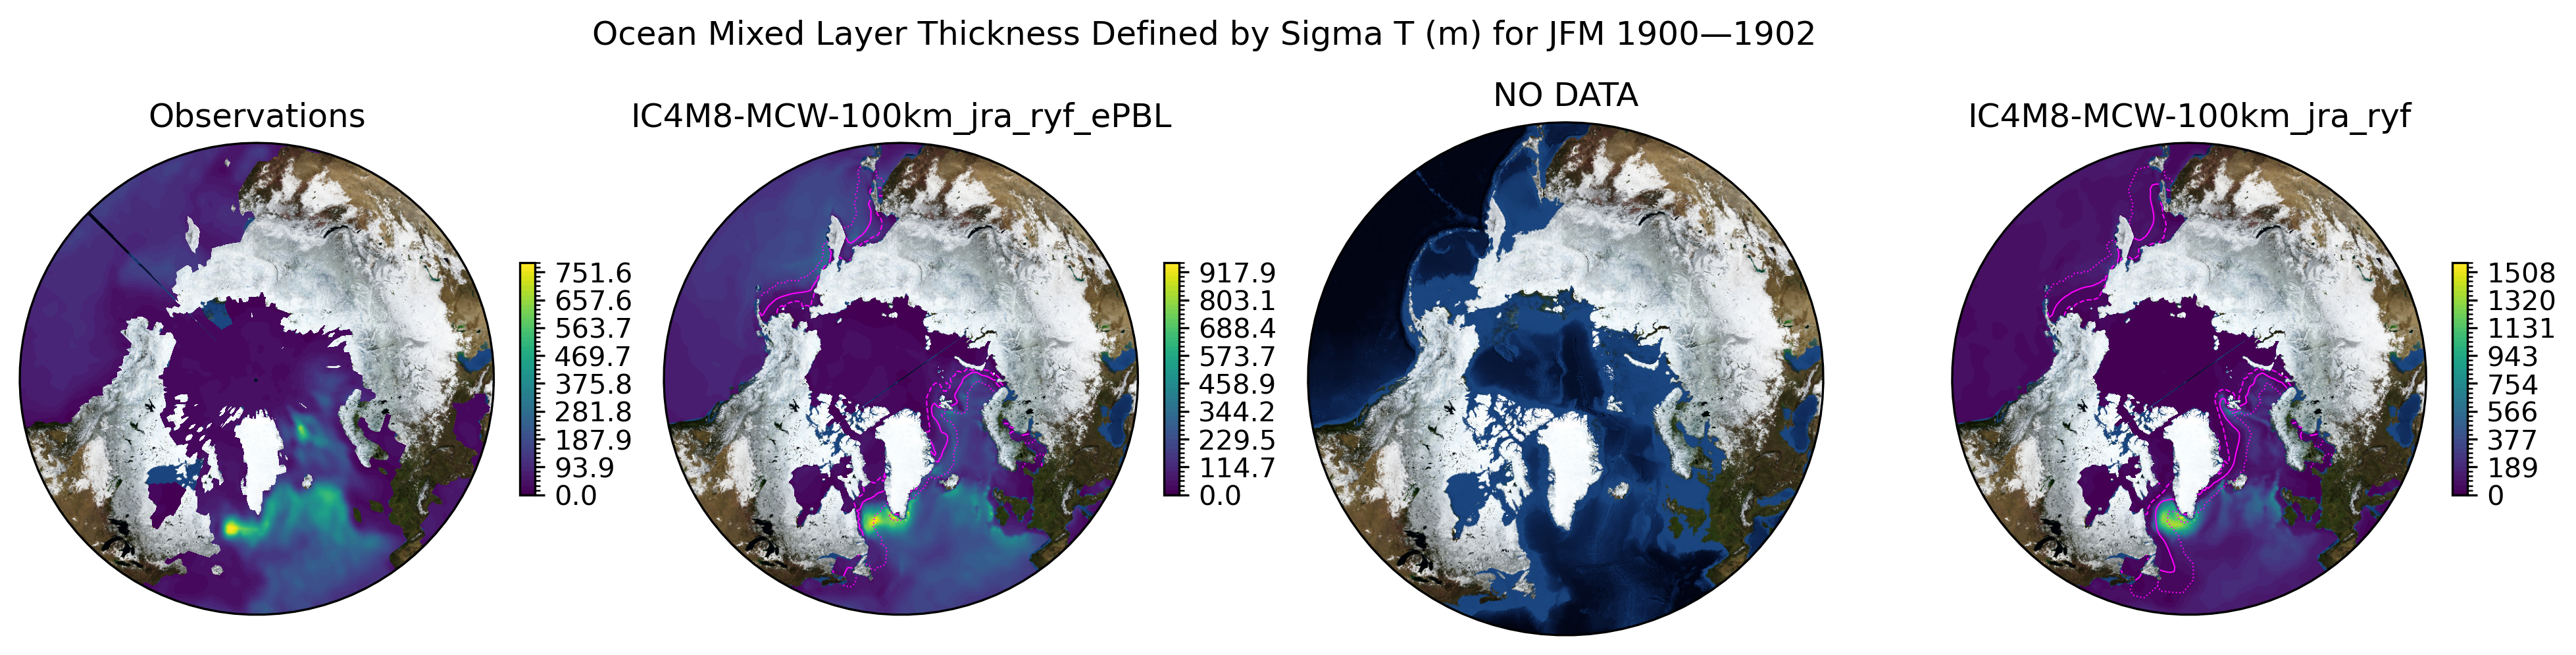

In [76]:
hemisphere = "north"
vmax = None

fig, axes = make_fig(number_panels=4, hemisphere=hemisphere)

plot(MLDobs_JFM_mean,
    levels=51,
    vmin=0,
    vmax=vmax,
    # extend="max",
    cmap='viridis',
    ax=axes[0],
    title="Observations",
    hemisphere=hemisphere
    )


plot(model_JFM_mld_epbl['mlotst'],
    dat_ice=model_JFM_aice_epbl,
    levels=51,
    vmin=0,
    vmax=vmax,
    # extend="max",
    cmap='viridis',
    ax=axes[1],
    title=exptname_epbl,
    hemisphere=hemisphere
    )


# plot(model_JFM_mld_kpp['mlotst'],
#     dat_ice=model_JFM_aice_kpp,
#     levels=51,
#     vmin=0,
#     vmax=None,
#     # extend="max",
#     cmap='viridis',
#     ax=axes[2],
#     title=exptname_kpp,
#     hemisphere=hemisphere
#     )


plot(model_JFM_mld_ctrl['mlotst'],
    dat_ice=model_JFM_aice_ctrl,
    levels=51,
    vmin=0,
    vmax=vmax,
    # extend="max",
    cmap='viridis',
    ax=axes[3],
    title=exptname_ctrl,
    hemisphere=hemisphere
    )

fig.suptitle(
    f"{mld_ctrl['mlotst'].attrs['long_name']} ({mld_ctrl['mlotst'].attrs['units']}) for JFM "
    f"{datestart_ctrl.strftime('%Y')}—{datestop_ctrl.strftime('%Y')}",   
    y=0.95
)

### Plot the MLD for the Southern Ocean

Text(0.5, 0.95, 'Ocean Mixed Layer Thickness Defined by Sigma T (m) for JFM 1900—1902')

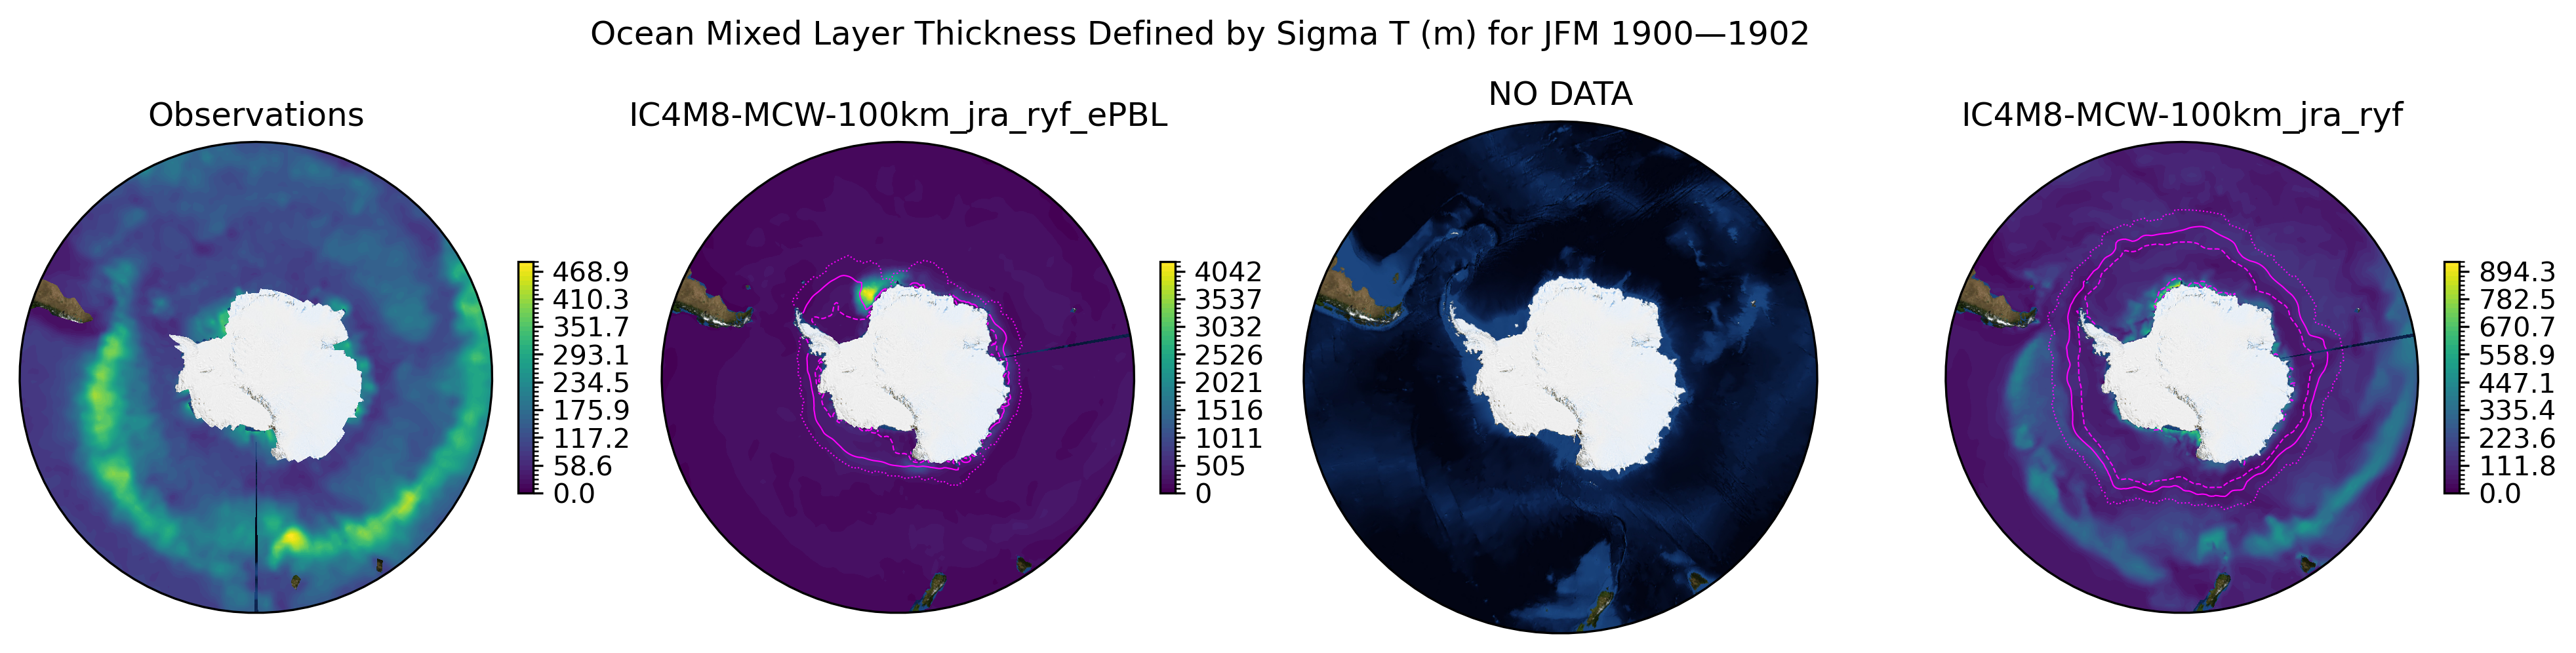

In [77]:
hemisphere = "south"

fig, axes = make_fig(number_panels=4, hemisphere=hemisphere)

plot(MLDobs_JAS_mean,
    levels=51,
    vmin=0,
    vmax=None,
    # extend="max",
    cmap='viridis',
    ax=axes[0],
    title="Observations",
    hemisphere=hemisphere
    )


plot(model_JAS_mld_epbl['mlotst'],
    dat_ice=model_JAS_aice_epbl,
    levels=51,
    vmin=0,
    vmax=None,
    # extend="max",
    cmap='viridis',
    ax=axes[1],
    title=exptname_epbl,
    hemisphere=hemisphere
    )


# plot(model_JAS_mld_kpp['mlotst'],
#     dat_ice=model_JAS_aice_kpp,
#     levels=51,
#     vmin=0,
#     vmax=None,
#     # extend="max",
#     cmap='viridis',
#     ax=axes[2],
#     title=exptname_kpp,
#     hemisphere=hemisphere
#     )


plot(model_JAS_mld_ctrl['mlotst'],
    dat_ice=model_JAS_aice_ctrl,
    levels=51,
    vmin=0,
    vmax=None,
    # extend="max",
    cmap='viridis',
    ax=axes[3],
    title=exptname_ctrl,
    hemisphere=hemisphere
    )

fig.suptitle(
    f"{mld_ctrl['mlotst'].attrs['long_name']} ({mld_ctrl['mlotst'].attrs['units']}) for JFM "
    f"{datestart_ctrl.strftime('%Y')}—{datestop_ctrl.strftime('%Y')}",   
    y=0.95
)

In [ ]:
client.close()